<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/%E6%AD%A3%E8%A6%8F%E5%88%86%E5%B8%83%E3%81%8B%E3%82%89%E3%81%AE%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1次元データの標準化(Zスコア)による異常検知（初心者向け・1セル版）
# 手順:
# 1) 1次元の正規分布（相当）から学習用の「正常」データを作成
# 2) テスト用に「正常＋異常」を混ぜたデータを作成
# 3) 学習データから平均・標準偏差を推定
# 4) Zスコアを計算し、標準正規のしきい値で異常判定（両側）
# 5) 可視化（元の値のヒスト＋PDF、Zスコアのヒスト＋PDF）

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [2]:
# 再現性があるようにランダムシードを固定
np.random.seed(0)

In [3]:
# ===== 1) 学習データ（正常）と 2) テストデータ（正常＋異常） =====
mu = 2.0          # 真の平均（説明用）
sigma = 1.5       # 真の標準偏差（説明用）

train = np.random.normal(mu, sigma, size=400)        # 学習：正常のみ
test_norm = np.random.normal(mu, sigma, size=200)    # テスト：正常

# 異常は平均を大きくずらして作成（分かりやすく）
mu_out = mu + 6.0
sigma_out = 1.0
test_out = np.random.normal(mu_out, sigma_out, size=20)

test = np.hstack([test_norm, test_out])
labels = np.hstack([np.zeros(len(test_norm), dtype=int), np.ones(len(test_out), dtype=int)])  # 0=正常,1=異常(真)

In [4]:

# ===== 3) 学習データから平均・標準偏差を推定 =====
mu_hat = train.mean()
sigma_hat = train.std(ddof=1)  # 不偏標準偏差

In [5]:


# ===== 4) Zスコアの計算＆しきい値で判定（両側） =====
def zscore(x, mu, s):
    return (x - mu) / s

Z = zscore(test, mu_hat, sigma_hat)

In [6]:
alpha = 0.99  # 「正常」とみなす両側の信頼水準（例: 0.99 → 有意水準1%）
# 両側判定なので、上側 (1+alpha)/2 点を使う（例: 0.995 → 約 2.575）
z_thr = norm.ppf((1 + alpha) / 2)

pred = (np.abs(Z) > z_thr).astype(int)  # |Z| がしきい値を超えたら「異常」

# 簡単な集計
tp = ((pred==1) & (labels==1)).sum()
fp = ((pred==1) & (labels==0)).sum()
fn = ((pred==0) & (labels==1)).sum()
precision = tp / (tp+fp) if (tp+fp)>0 else 0.0
recall    = tp / (tp+fn) if (tp+fn)>0 else 0.0

mean_hat=1.957, std_hat=1.484
two-sided z-threshold (alpha=0.99): ±2.576
TP=20, FP=4, FN=0
precision=0.833, recall=1.000


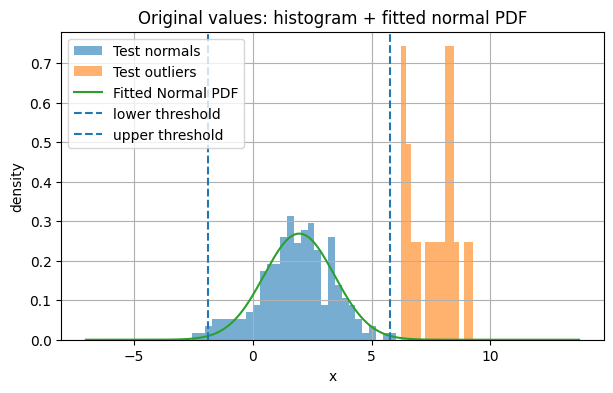

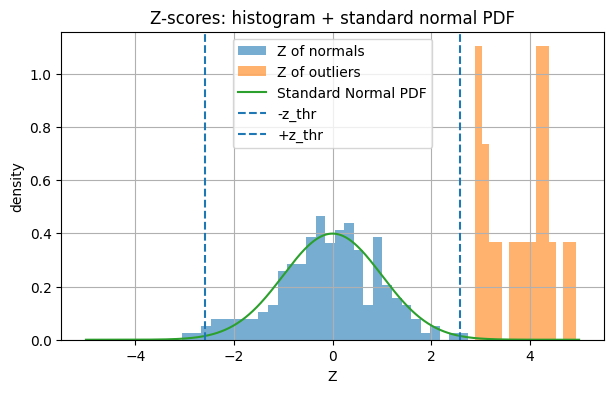

In [7]:
print(f"mean_hat={mu_hat:.3f}, std_hat={sigma_hat:.3f}")
print(f"two-sided z-threshold (alpha={alpha}): ±{z_thr:.3f}")
print(f"TP={tp}, FP={fp}, FN={fn}")
print(f"precision={precision:.3f}, recall={recall:.3f}")

# ===== 5) 可視化 =====
# (a) 元の値のヒストグラム + 推定正規PDF + しきい値（x空間の線）
x_grid = np.linspace(min(test.min(), train.min()) - 3*sigma_hat,
                     max(test.max(), train.max()) + 3*sigma_hat, 500)
pdf = norm.pdf(x_grid, loc=mu_hat, scale=sigma_hat)

x_thr_low  = mu_hat - z_thr * sigma_hat
x_thr_high = mu_hat + z_thr * sigma_hat

plt.figure(figsize=(7,4))
plt.hist(test[labels==0], bins=30, density=True, alpha=0.6, label="Test normals")
plt.hist(test[labels==1], bins=15, density=True, alpha=0.6, label="Test outliers")
plt.plot(x_grid, pdf, label="Fitted Normal PDF")
plt.axvline(x_thr_low,  linestyle='--', label="lower threshold")
plt.axvline(x_thr_high, linestyle='--', label="upper threshold")
plt.title("Original values: histogram + fitted normal PDF")
plt.xlabel("x"); plt.ylabel("density")
plt.legend(); plt.grid(True)
plt.show()

# (b) Zスコアのヒストグラム + 標準正規PDF + しきい値（±z）
z_grid = np.linspace(-5, 5, 500)
std_pdf = norm.pdf(z_grid)  # 標準正規 N(0,1)

plt.figure(figsize=(7,4))
plt.hist(Z[labels==0], bins=30, density=True, alpha=0.6, label="Z of normals")
plt.hist(Z[labels==1], bins=15, density=True, alpha=0.6, label="Z of outliers")
plt.plot(z_grid, std_pdf, label="Standard Normal PDF")
plt.axvline(-z_thr, linestyle='--', label=f"-z_thr")
plt.axvline( z_thr, linestyle='--', label=f"+z_thr")
plt.title("Z-scores: histogram + standard normal PDF")
plt.xlabel("Z"); plt.ylabel("density")
plt.legend(); plt.grid(True)
plt.show()
